# Курсовая работа
- Дисциплина: 	Технологии анализа данных и машинного обучения
- Тема: Создание и использование набора данных об экономической активности компаний для задач машинного обучения

В данном файле находится код курсовой работы, а также все необходимые комментарии по алгоритму.

В работе используются следующие библиотеки:
- re - библиотека регулярных выражений. Использованы функции для написания регулярных выражений, в частности заимствованы compile - компиляция регулярного выражения и findall - нахождение заданного шаблона в тексте.
- reguests - библиотека HTTP - запросов в сети Интернет. Использованы функции для отправки HTTP запросов  на сайт, в частности для получения информации необходима функция get.
- pandas - библиотека для работы с табличными данными. Использованы функции для чтения исходного csv файла, записи, обработки и сохрания промежуточных данных в отдельные таблицы.
- numpy - библиотека для математических вычислений. Использована структура данных np.Nan для отсутсвующих значений. 
- swifter - библиотека для параллельных вычислений табличных данных. Совмещает в себе некоторый функционал библиотек pandas и структуры данных dask.dataframe
- fake_useragent - библиотека для создания случайных пользовательских данных об устройстве

In [ ]:
# !pip install fake_useragent
# !pip install swifter
# !pip install yellowbrick

In [1]:
import re
import requests
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from fake_useragent import UserAgent
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

## Чтение и организация входных данных

Для исходного файла создаётся столбец с индексом, который равен рейтингу компании. Затем исходный csv файл разбивается на 10 отдельных составных файлов в определённую папку. Также создается папка, где хранятся результаты будущих вычислений

In [ ]:
mkdir data

In [ ]:
mkdir results

In [ ]:
data = pd.read_csv('spark_top50k.csv',
                   dtype={'Наименование':object, 'Выручка, ₽':object, 'ИНН':object, 'rank':'Int64'})

data['rank'] = data.index
data['rank'].astype('Int64')
data.to_csv('spark_top50k_ranked.csv', index=False)

for i,chunk in enumerate(pd.read_csv('spark_top50k_ranked.csv', chunksize=5_000)):
    chunk.to_csv(f'data/spark_{i}.csv', index=False)

## Автоматизированный сбор информациии

Сбор данных производится с интернет-сервиса excheck.pro. Парсер - автоматизированный сценарий сбора информации с интернет-сайта работает по следующему алгоритму:
1. Генерирование случайных пользовательских данных для заголовка HTTP запроса
2. Компиляция регулярных выражений, которые будут находить необходимый шаблон из HTML страницы
3. Отправка GET - запроса к сайту со ссылкой на https://excheck.pro/company/ИНН и дешифрование содержания страницы из бинарного формата.
4. Нахождение информации с помощью регулярных выражений и сохранение идентификационных данных в отдельный словарь. 
5. Переход на страницы https://excheck.pro/company/ИНН/finances?type=results и https://excheck.pro/company/{inn}/finances?type=balance, которые содержат информацию о финансовой отчетностей - формы о финансовых результатах и бухгалтерского баланса, соответственно. Как и в шаге 3, происходит поиск информации с помощью регулрных выражений, после чего результаты  сохраняются в вышеупомянутый словарь
6. Для денежных результатов, полученных в формате "число разряд (в текстовом формате) валюта", производится перевод в числовой формат с помощью отдельной функции
7. Итоговый словарь форматируется в структуру данных pd.Series. В случае ошибки, которая возникает из-за наличия некорректных данных (согласно выписке из ЕГРЮЛ), парсер возвращает пустую строку с np.NaN значением
Парсер собирает слудюещие данные
### Идентификационные данные
- ИНН
- Дата регистрации
- Адрес
- ОКВЭД (и расшифровка)
- ОГРН
- КПП
- ОКПО
- ОКОПФ (и расшифровка)
- ОКФС (и расшифровка)
- ОКАТО (и расшифровка)

### Основные фин показатели
- Год фин результаты
- Выручка
- Чистая прибыль
- Капитал

### Последние показатели отчета о фин результатах
- Себестоимость
- Коммерческие расходы
- Управленческие расходы
- Текущий налог на прибыль
- Чистая прибыль
- Совокупный финансовый результат

### Последние показатели баланса
- Основные средства
- Внеоборотные активы
- Запасы
- НДС
- Дебиторская задолженность
- Денежные средства
- Оборотные активы
- БАЛАНС
- Уставный капитал
- Нераспределенная прибыль
- Долгосрочные обязательства
- Кредиторская задолженность
- Краткосрочные обязательства

In [2]:
ua = UserAgent()
user_agent = {'User-agent' : ua.random}
user_agent

{'User-agent': 'Mozilla/5.0 (X11; U; Linux x86_64; en-US) AppleWebKit/532.0 (KHTML, like Gecko) Chrome/4.0.207.0 Safari/532.0'}

Регулярные выражения построены по принципу "ключевое слово - html элементы страницы". Для показателей финансовой отчетности используются номера строк из РСБУ

In [3]:
date_of_regist = re.compile(r"Дата регистрации</div>\s<div>(.*)</div>")
address = re.compile(r"Юридический адрес</div>\s<div>(.*)\s</div>")
okved = re.compile(r"Основной вид деятельности</div>\s(?:.*)=([.\d]+)\">(.*)</a>")

ogrn = re.compile(r"ОГРН (\d+)")
kpp = re.compile(r"КПП(?:.*)>(\d+)")
okpo = re.compile(r"ОКПО(?:.*)>(\d+)")

okopf = re.compile(r"ОКОПФ</td>[\s]+(?:.*)>(\d+)</a>\s+(?:.*)>(.*)</div>")
okfs = re.compile(r"ОКФС</td>[\s]+(?:.*)>(\d+)</a>\s+(?:.*)>(.*)</div>")
okato = re.compile(r"ОКАТО</td>[\s]+(?:.*)>(\d+)</a>\s+(?:.*)>(.*)</div>")

year_fin = re.compile(r"Финансовые результаты за (\d+) год")
main_fin = re.compile(r"<div class=\"pt-1 pb-1 fs-5 lh-1(?:.*)\">(.*)</div>")

cost_price = re.compile(r"2120</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
commercial = re.compile(r"2210</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
management = re.compile(r"2220</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
taxes = re.compile(r"2411</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
comprehensive_income = re.compile(r"2500</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")

main_assets = re.compile(r"1150</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
non_fixed_assets = re.compile(r"1100</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")

inventories = re.compile(r"1210</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
nds = re.compile(r"1220</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
receivable = re.compile(r"1230</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
money_assets = re.compile(r"1250</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
total_assets = re.compile(r"1200</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
assets = re.compile(r"1600</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")

auth_capital = re.compile(r"1310</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
non_distributed = re.compile(r"1370</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")

long_term = re.compile(r"1400</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")

payable = re.compile(r"1520</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")
short_term = re.compile(r"1500</div></td>\s<td class=\"w-25\">\s+<span class=\"(?:.*)>(.*)</span>")


In [4]:
def convert_unit(res:str):
    '''
    Функция конвертации денежных показатлей. На вход подается строка в формате "число разряд валюта". Затем 
    '''
    res = res.split()
       
    if 'dash' in res[0] or '0' == res[0]:
        return 0
   
    num = float(res[0].replace(',', '.'))
    
    if 'млрд' in res[1]:
        return int(num * 10 ** 9)
    elif 'млн' in res[1]:
        return int(num * 10 ** 6)
    elif 'трлн' in res[1]:
        return int(num * 10 ** 12)
    else:
        return int(num * 10 ** 3)
    
    

def get_info(inn:str, useragent:dict) -> pd.Series:
    try:
        '''
        Функция сбора данных. 
        На вход подается ИНН, который станет ключевым параметром компании для создания ссылки. 
        В начале парсер переходит на страничку компании по ИНН. 
        После сбора основных данных парсер переходит на страницы с фин отчетностями.
        На выходе получается pd.Series с заполненными данными или np.NaN в случае отсутсвия или недостоверности данных
        '''
        company = {}
        url = f'https://excheck.pro/company/{inn}'
        headers = useragent
        response = requests.get(url, headers=headers)
        content = response.content.decode()

        company['ИНН'] = inn
        company['Дата регистрации'] = re.findall(date_of_regist, content)[0]
        company['Адрес'] = re.findall(address, content)[0]
        company['ОКВЭД'] = re.findall(okved, content)[0][0]
        company['ОКВЭД (расшифровка)'] = re.findall(okved, content)[0][1]

        company['ОГРН'] = re.findall(ogrn, content)[0]
        company['КПП'] = re.findall(kpp, content)[0]
        company['ОКПО'] = re.findall(okpo, content)[0]

        company['ОКОПФ'] = re.findall(okopf, content)[0][0]
        company['ОКОПФ (расшифровка)'] = re.findall(okopf, content)[0][1]
        company['ОКФС'] = re.findall(okfs, content)[0][0]
        company['ОКФС (расшифровка)'] = re.findall(okfs, content)[0][1]
        company['ОКАТО'] = re.findall(okato, content)[0][0]
        company['ОКАТО (расшифровка)'] = re.findall(okato, content)[0][1]
        
        company['Год фин результатов'] = re.findall(year_fin, content)[0]
        fin_info = re.findall(main_fin, content)
        company['Выручка'] = convert_unit(fin_info[0])
        company['Чистая прибыль'] = convert_unit(fin_info[1])
        company['Капитал'] = convert_unit(fin_info[2])
        
        url = f'https://excheck.pro/company/{inn}/finances?type=results'
        response = requests.get(url, headers=headers)
        content = response.content.decode()
        
        company['Себестоимость'] = convert_unit(re.findall(cost_price, content)[0])
        company['Коммерческие расходы'] = convert_unit(re.findall(commercial, content)[0])
        company['Управленческие расходы'] = convert_unit(re.findall(management, content)[0])
        company['Текущий налог на прибыль'] = convert_unit(re.findall(taxes, content)[0])
        company['Совокупный финансовый результат'] = convert_unit(re.findall(comprehensive_income, content)[0])
        
        url = f'https://excheck.pro/company/{inn}/finances?type=balance'
        response = requests.get(url, headers=headers)
        content = response.content.decode()
        
        company['Основные средства'] = convert_unit(re.findall(main_assets, content)[0])
        company['Внеоборотные активы'] = convert_unit(re.findall(non_fixed_assets, content)[0])
        company['Запасы'] = convert_unit(re.findall(inventories, content)[0])
        company['НДС'] = convert_unit(re.findall(nds, content)[0])
        company['Дебиторская задолженность'] = convert_unit(re.findall(receivable, content)[0])
        company['Денежные средства'] = convert_unit(re.findall(money_assets, content)[0])
        company['Оборотные активы'] = convert_unit(re.findall(total_assets, content)[0])
        company['Баланс'] = convert_unit(re.findall(assets, content)[0])
        company['Уставный капитал'] = convert_unit(re.findall(auth_capital, content)[0])
        company['Нераспределенная прибыль'] = convert_unit(re.findall(non_distributed, content)[0])
        company['Долгосрочные обязательства'] = convert_unit(re.findall(long_term, content)[0])
        company['Кредиторская задолженность'] = convert_unit(re.findall(payable, content)[0])
        company['Кратосрочные обязательства'] = convert_unit(re.findall(short_term, content)[0])

        return pd.Series(company)
    
    except:
        return pd.Series(np.NaN)



Для конкретного набор данных производится чтение csv файла и создание временнного файла со всеми необходимыми столбцами. Столбец со значением ИНН копируется во временную таблицу. Затем значения столбца с ИНН используются, в качестве аргумента функции get_info. Применяя функцию ко всему столбцу, swifter производит параллельные вычисления. В результате возвращается таблица со всеми необходимыми данными. Так как некоторые компании содержат некорректную информацию, возникает отдельный столбец 0, который является индикатором некорректных данных. Убирается столбец, возникаемый из-за "некорректных" компаний, добавляются столбцы с рейтингом и наименованием из исходного файла, затем результат вычислений сохраняется в отдельную файл в формате *.csv

In [5]:
df = pd.read_csv('data/spark_10.csv', 
                 dtype={'Наименование':object, 'Выручка, ₽':object, 'ИНН':object, 'rank':'Int64'})
df

,Наименование,"Выручка, ₽",ИНН,rank
0,"ООО ""ВТК""",491 млн,3444163193,50000
1,"ЗАО ""НЕФТЕФЛОТ""",491 млн,6314010931,50001
2,ООО СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИК УДСД,491 млн,8904070077,50002
3,"ООО ""ТД ""ВИКА""",491 млн,4205200135,50003
4,"ООО""ВУД-МАРКЕТ""",491 млн,9715283378,50004
...,...,...,...,...
995,"ООО ""ЭСКОРТ ГРУПП""",479 млн,7722697432,50995
996,"ООО ""ТД-АС""",479 млн,7723591855,50996
997,"ООО ""ЙОСТ ТАТ""",479 млн,1650167023,50997
998,"ООО ""САФАРИПАРК""",479 млн,2304058310,50998


In [6]:
temp = pd.DataFrame(columns=['ИНН', 'Дата регистрации',
       'Адрес', 'ОКВЭД', 'ОКВЭД (расшифровка)', 'ОГРН', 'КПП', 'ОКПО', 'ОКОПФ',
       'ОКОПФ (расшифровка)', 'ОКФС', 'ОКФС (расшифровка)', 'ОКАТО',
       'ОКАТО (расшифровка)', 'Год фин результатов', 'Выручка',
       'Чистая прибыль', 'Капитал', 'Себестоимость', 'Коммерческие расходы',
       'Управленческие расходы', 'Текущий налог на прибыль',
       'Совокупный финансовый результат', 'Основные средства',
       'Внеоборотные активы', 'Запасы', 'НДС', 'Дебиторская задолженность',
       'Денежные средства', 'Оборотные активы', 'Баланс', 'Уставный капитал',
       'Нераспределенная прибыль', 'Долгосрочные обязательства',
       'Кредиторская задолженность', 'Кратосрочные обязательства'])
temp['ИНН'] = df["ИНН"]
temp.head()

,ИНН,Дата регистрации,Адрес,ОКВЭД,ОКВЭД (расшифровка),ОГРН,КПП,ОКПО,ОКОПФ,ОКОПФ (расшифровка),...,НДС,Дебиторская задолженность,Денежные средства,Оборотные активы,Баланс,Уставный капитал,Нераспределенная прибыль,Долгосрочные обязательства,Кредиторская задолженность,Кратосрочные обязательства
0,3444163193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6314010931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8904070077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4205200135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9715283378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
temp = temp['ИНН'].swifter.apply(lambda x: get_info(x, user_agent))
temp

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

,ИНН,Дата регистрации,Адрес,ОКВЭД,ОКВЭД (расшифровка),ОГРН,КПП,ОКПО,ОКОПФ,ОКОПФ (расшифровка),...,Дебиторская задолженность,Денежные средства,Оборотные активы,Баланс,Уставный капитал,Нераспределенная прибыль,Долгосрочные обязательства,Кредиторская задолженность,Кратосрочные обязательства,0
0,3444163193,12 сентября 2008 года,"109341, г. Москва, ул. Люблинская, д. 151, эт....",47.75,Торговля розничная косметическими и товарами л...,1083444008207,772301001,87278994,12300,Общества с ограниченной ответственностью,...,10100000.0,1.910000e+07,1.405000e+08,1.407000e+08,20000.0,81500000.0,0.0,5.500000e+07,5.920000e+07,NaN
1,6314010931,25 января 1996 года,"443042, Самарская область, г. Самара, ул. Бело...",30.11,"Строительство кораблей, судов и плавучих конст...",1026300893519,631401001,42528318,12267,Непубличные акционерные общества,...,342400000.0,5.300000e+09,6.600000e+09,7.200000e+09,87700000.0,68600000.0,189500000.0,6.400000e+09,6.500000e+09,NaN
2,8904070077,5 октября 2012 года,"629305, Ямало-Ненецкий автономный округ, г. Но...",71.11.1,"Деятельность в области архитектуры, связанная ...",1128904007484,890401001,12487705,12300,Общества с ограниченной ответственностью,...,210200000.0,5.860000e+07,4.645000e+08,5.204000e+08,80000000.0,69100000.0,178600000.0,1.731000e+08,1.928000e+08,NaN
3,4205200135,18 мая 2010 года,"650021, Кемеровская область - Кузбасс, г. Кеме...",46.75,Торговля оптовая химическими продуктами,1104205008335,420501001,65163919,12300,Общества с ограниченной ответственностью,...,77500000.0,2.500000e+06,1.233000e+08,1.239000e+08,10000.0,20700000.0,0.0,2.900000e+07,1.032000e+08,NaN
4,9715283378,21 ноября 2016 года,"127410, г. Москва, Алтуфьевское шоссе, д. 41А,...",46.73,"Торговля оптовая лесоматериалами, строительным...",5167746350591,771501001,05644529,12300,Общества с ограниченной ответственностью,...,64500000.0,3.130000e+07,0.000000e+00,2.974000e+08,0.0,0.0,0.0,5.770000e+07,0.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7722697432,9 октября 2009 года,"115280, г. Москва, ул. Автозаводская, д. 23А, ...",46.43.2,"Торговля оптовая радио-, теле- и видеоаппарату...",1097746608915,772501001,63652583,12300,Общества с ограниченной ответственностью,...,115700000.0,2.084000e+08,6.017000e+08,6.587000e+08,16000.0,615100000.0,6200000.0,3.550000e+07,3.730000e+07,NaN
996,7723591855,13 ноября 2006 года,"143082, Московская область, г. Одинцово, д. Ра...",46.46,Торговля оптовая фармацевтической продукцией,1067759619465,503201001,98225127,12300,Общества с ограниченной ответственностью,...,28700000.0,1.000000e+07,0.000000e+00,7.360000e+07,0.0,0.0,0.0,7.500000e+06,0.000000e+00,NaN
997,1650167023,22 ноября 2007 года,"423800, республика Татарстан, г. Набережные Че...",29.32,Производство прочих комплектующих и принадлежн...,1071650029186,165001001,83469540,12300,Общества с ограниченной ответственностью,...,75700000.0,1.220000e+07,2.066000e+08,2.095000e+08,2000000.0,196400000.0,27000.0,1.090000e+07,1.090000e+07,NaN
998,2304058310,13 августа 2010 года,"353460, Краснодарский край, г. Геленджик, тер....",91.04.1,Деятельность зоопарков,1102304001700,230401001,68460629,12300,Общества с ограниченной ответственностью,...,20000000.0,1.705000e+08,0.000000e+00,2.554000e+08,0.0,0.0,0.0,1.000000e+06,0.000000e+00,NaN


In [8]:
temp[['ИНН', 'rank', 'Наименование']] = df[['ИНН', 'rank', 'Наименование']]
temp = temp.drop([0], axis=1)
temp

,ИНН,Дата регистрации,Адрес,ОКВЭД,ОКВЭД (расшифровка),ОГРН,КПП,ОКПО,ОКОПФ,ОКОПФ (расшифровка),...,Денежные средства,Оборотные активы,Баланс,Уставный капитал,Нераспределенная прибыль,Долгосрочные обязательства,Кредиторская задолженность,Кратосрочные обязательства,rank,Наименование
0,3444163193,12 сентября 2008 года,"109341, г. Москва, ул. Люблинская, д. 151, эт....",47.75,Торговля розничная косметическими и товарами л...,1083444008207,772301001,87278994,12300,Общества с ограниченной ответственностью,...,1.910000e+07,1.405000e+08,1.407000e+08,20000.0,81500000.0,0.0,5.500000e+07,5.920000e+07,50000,"ООО ""ВТК"""
1,6314010931,25 января 1996 года,"443042, Самарская область, г. Самара, ул. Бело...",30.11,"Строительство кораблей, судов и плавучих конст...",1026300893519,631401001,42528318,12267,Непубличные акционерные общества,...,5.300000e+09,6.600000e+09,7.200000e+09,87700000.0,68600000.0,189500000.0,6.400000e+09,6.500000e+09,50001,"ЗАО ""НЕФТЕФЛОТ"""
2,8904070077,5 октября 2012 года,"629305, Ямало-Ненецкий автономный округ, г. Но...",71.11.1,"Деятельность в области архитектуры, связанная ...",1128904007484,890401001,12487705,12300,Общества с ограниченной ответственностью,...,5.860000e+07,4.645000e+08,5.204000e+08,80000000.0,69100000.0,178600000.0,1.731000e+08,1.928000e+08,50002,ООО СПЕЦИАЛИЗИРОВАННЫЙ ЗАСТРОЙЩИК УДСД
3,4205200135,18 мая 2010 года,"650021, Кемеровская область - Кузбасс, г. Кеме...",46.75,Торговля оптовая химическими продуктами,1104205008335,420501001,65163919,12300,Общества с ограниченной ответственностью,...,2.500000e+06,1.233000e+08,1.239000e+08,10000.0,20700000.0,0.0,2.900000e+07,1.032000e+08,50003,"ООО ""ТД ""ВИКА"""
4,9715283378,21 ноября 2016 года,"127410, г. Москва, Алтуфьевское шоссе, д. 41А,...",46.73,"Торговля оптовая лесоматериалами, строительным...",5167746350591,771501001,05644529,12300,Общества с ограниченной ответственностью,...,3.130000e+07,0.000000e+00,2.974000e+08,0.0,0.0,0.0,5.770000e+07,0.000000e+00,50004,"ООО""ВУД-МАРКЕТ"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7722697432,9 октября 2009 года,"115280, г. Москва, ул. Автозаводская, д. 23А, ...",46.43.2,"Торговля оптовая радио-, теле- и видеоаппарату...",1097746608915,772501001,63652583,12300,Общества с ограниченной ответственностью,...,2.084000e+08,6.017000e+08,6.587000e+08,16000.0,615100000.0,6200000.0,3.550000e+07,3.730000e+07,50995,"ООО ""ЭСКОРТ ГРУПП"""
996,7723591855,13 ноября 2006 года,"143082, Московская область, г. Одинцово, д. Ра...",46.46,Торговля оптовая фармацевтической продукцией,1067759619465,503201001,98225127,12300,Общества с ограниченной ответственностью,...,1.000000e+07,0.000000e+00,7.360000e+07,0.0,0.0,0.0,7.500000e+06,0.000000e+00,50996,"ООО ""ТД-АС"""
997,1650167023,22 ноября 2007 года,"423800, республика Татарстан, г. Набережные Че...",29.32,Производство прочих комплектующих и принадлежн...,1071650029186,165001001,83469540,12300,Общества с ограниченной ответственностью,...,1.220000e+07,2.066000e+08,2.095000e+08,2000000.0,196400000.0,27000.0,1.090000e+07,1.090000e+07,50997,"ООО ""ЙОСТ ТАТ"""
998,2304058310,13 августа 2010 года,"353460, Краснодарский край, г. Геленджик, тер....",91.04.1,Деятельность зоопарков,1102304001700,230401001,68460629,12300,Общества с ограниченной ответственностью,...,1.705000e+08,0.000000e+00,2.554000e+08,0.0,0.0,0.0,1.000000e+06,0.000000e+00,50998,"ООО ""САФАРИПАРК"""


In [ ]:
temp.to_csv('results/spark10_res.csv', index=False)

Сбор данных из промежуточных файлов в один крупный csv файл

In [ ]:
df_csv_concat = pd.DataFrame()
csv_files = [f'results/spark{i}_res.csv' for i in range(11)]
csv_files
for i in range(10):
    df_csv_concat = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True) 
    
df_csv_concat.to_csv('spark_final.csv', index=False)

## Машинное обучение

In [9]:
types_cols = {'ИНН':object, 'Дата регистрации':object, 'Адрес':object, 'ОКВЭД':object, 
              'ОКВЭД (расшифровка)':object, 'ОГРН':object, 'КПП':object, 'ОКПО':object,
              'ОКОПФ':object, 'ОКОПФ (расшифровка)':object, 'ОКФС':object,
       'ОКФС (расшифровка)':object, 'ОКАТО':object, 'ОКАТО (расшифровка)':object,
       'Год фин результатов':object, 'Выручка':'Int64', 'Чистая прибыль':'Int64', 'Капитал':'Int64',
       'Себестоимость':'Int64', 'Коммерческие расходы':'Int64', 'Управленческие расходы':'Int64',
       'Текущий налог на прибыль':'Int64', 'Совокупный финансовый результат':'Int64',
       'Основные средства':'Int64', 'Внеоборотные активы':'Int64', 'Запасы':'Int64', 'НДС':'Int64',
       'Дебиторская задолженность':'Int64', 'Денежные средства':'Int64', 'Оборотные активы':'Int64',
       'Баланс':'Int64', 'Уставный капитал':'Int64', 'Нераспределенная прибыль':'Int64',
       'Долгосрочные обязательства':'Int64', 'Кредиторская задолженность':'Int64',
       'Кратосрочные обязательства':'Int64', 'rank':'Int64', 'Наименование':object}
df = pd.read_csv('spark_final.csv', dtype=types_cols)
df

,ИНН,Дата регистрации,Адрес,ОКВЭД,ОКВЭД (расшифровка),ОГРН,КПП,ОКПО,ОКОПФ,ОКОПФ (расшифровка),...,Денежные средства,Оборотные активы,Баланс,Уставный капитал,Нераспределенная прибыль,Долгосрочные обязательства,Кредиторская задолженность,Кратосрочные обязательства,rank,Наименование
0,7706107510,7 декабря 1995 года,"115035, г. Москва, Софийская набережная, д. 26/1",06.10.1,Добыча нефти,1027700043502,770601001,44428,45286596000,Якиманка,...,5985000000,46000000000,12300000000000,1060000,20000000000,71000000000,23000000000,32000000000,0,"ПАО ""НК ""РОСНЕФТЬ"""
1,7736050003,25 февраля 1993 года,"197229, г. Санкт-Петербург, пр-кт Лахтинский, ...",46.71,"Торговля оптовая твердым, жидким и газообразны...",1027700070518,781401001,40778,45293590000,Черемушки,...,2475000000,4099999999999,24000000000000,1184000000,16399999999999,50000000000,13000000000,23000000000,1,"ПАО ""ГАЗПРОМ"""
2,5504036333,6 октября 1995 года,"190000, г. Санкт-Петербург, ул. Почтамтская, д...",46.71,"Торговля оптовая твердым, жидким и газообразны...",1025501701686,783801001,42045241,40262000000,Адмиралтейский,...,3862000000,10000000000,2500000000000,76000,6674000000,6775000000,8314000000,12000000000,2,"ПАО ""ГАЗПРОМ НЕФТЬ"""
3,7708004767,22 апреля 1993 года,"101000, г. Москва, бульвар Сретенский, д. 11",71.12.3,"Работы геолого-разведочные, геофизические и ге...",1027700035769,770801001,44434,45286565000,Красносельский,...,3149000000,9344000000,2300000000000,173000,13000000000,852000000,3599000000,9339000000,3,"ПАО ""ЛУКОЙЛ"""
4,7708503727,23 сентября 2003 года,"107174, г. Москва, ул. Новая Басманная, д. 2/1...",49.20,Деятельность железнодорожного транспорта: груз...,1037739877295,770801001,83262,45286555000,Басманный,...,465000000,3162000000,7400000000000,25000000000,3472000000,17000000000,4726000000,8596000000,4,"ОАО ""РЖД"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50995,7722697432,9 октября 2009 года,"115280, г. Москва, ул. Автозаводская, д. 23А, ...",46.43.2,"Торговля оптовая радио-, теле- и видеоаппарату...",1097746608915,772501001,63652583,45290594000,Южнопортовый,...,2084000,6017000,658700000,160,6151000,62000,355000,373000,50995,"ООО ""ЭСКОРТ ГРУПП"""
50996,7723591855,13 ноября 2006 года,"143082, Московская область, г. Одинцово, д. Ра...",46.46,Торговля оптовая фармацевтической продукцией,1067759619465,503201001,98225127,46455000641,д Раздоры,...,100000,0,73600000,0,0,0,75000,0,50996,"ООО ""ТД-АС"""
50997,1650167023,22 ноября 2007 года,"423800, республика Татарстан, г. Набережные Че...",29.32,Производство прочих комплектующих и принадлежн...,1071650029186,165001001,83469540,92430000000,Набережные Челны,...,122000,2066000,209500000,20000,1964000,270,109000,109000,50997,"ООО ""ЙОСТ ТАТ"""
50998,2304058310,13 августа 2010 года,"353460, Краснодарский край, г. Геленджик, тер....",91.04.1,Деятельность зоопарков,1102304001700,230401001,68460629,3408000000,Геленджик,...,1705000,0,255400000,0,0,0,10000,0,50998,"ООО ""САФАРИПАРК"""


## EDA

В датасете имеются следующие признаки

In [10]:
df.columns

Index(['ИНН', 'Дата регистрации', 'Адрес', 'ОКВЭД', 'ОКВЭД (расшифровка)',
       'ОГРН', 'КПП', 'ОКПО', 'ОКОПФ', 'ОКОПФ (расшифровка)', 'ОКФС',
       'ОКФС (расшифровка)', 'ОКАТО', 'ОКАТО (расшифровка)',
       'Год фин результатов', 'Выручка', 'Чистая прибыль', 'Капитал',
       'Себестоимость', 'Коммерческие расходы', 'Управленческие расходы',
       'Текущий налог на прибыль', 'Совокупный финансовый результат',
       'Основные средства', 'Внеоборотные активы', 'Запасы', 'НДС',
       'Дебиторская задолженность', 'Денежные средства', 'Оборотные активы',
       'Баланс', 'Уставный капитал', 'Нераспределенная прибыль',
       'Долгосрочные обязательства', 'Кредиторская задолженность',
       'Кратосрочные обязательства', 'rank', 'Наименование'],
      dtype='object')

Корреляционная матрица отражает экономическую взаимосвязь между показателями бухгалтерской отчетности

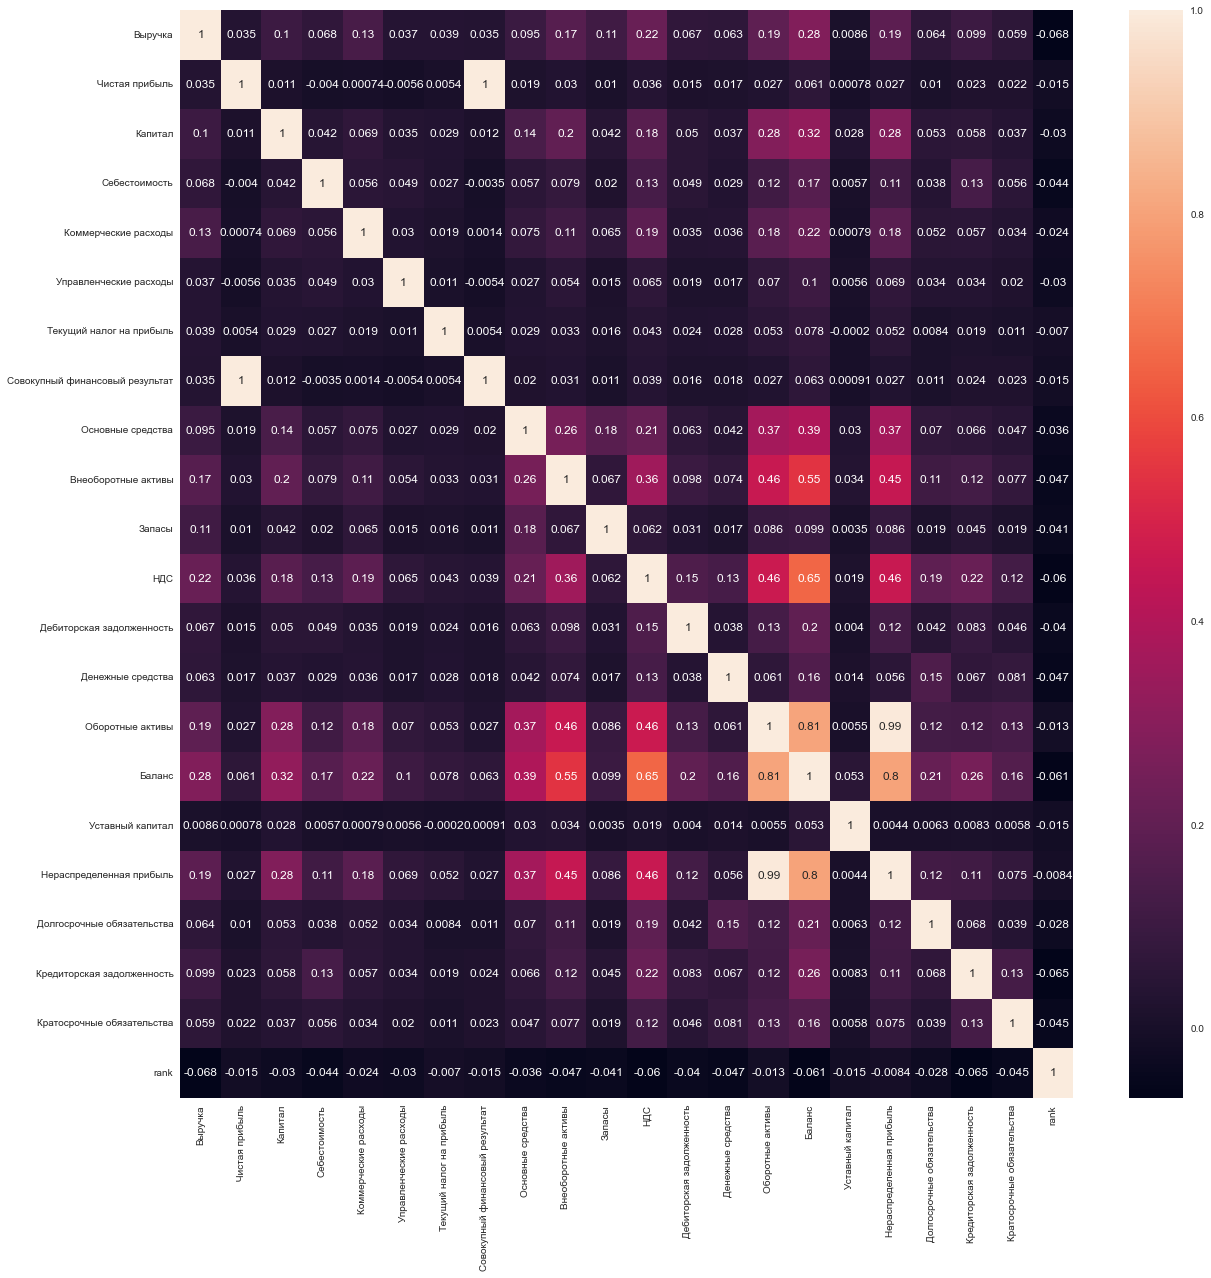

In [11]:
corrmat = df.corr()
plt.figure(figsize=(20, 20))  
sns.heatmap(corrmat, annot=True);

Для основных категориальных значений определены следующие моды - наиболее часто втречающие значения

In [12]:
obj_types = ['ОКВЭД (расшифровка)',
             'ОКФС (расшифровка)', 
             'ОКАТО']
for i in obj_types:
    print(df[i].mode())

0    Строительство жилых и нежилых зданий
Name: ОКВЭД (расшифровка), dtype: object
0    Общества с ограниченной ответственностью
Name: ОКФС (расшифровка), dtype: object
0    45286575000
Name: ОКАТО, dtype: object


Количество отсутствующих значений - компаний с некорректным ИНН или предоставленной в ЕГРЮЛ информацией

In [13]:
df.isna().sum()

ИНН                                   0
Дата регистрации                   2176
Адрес                              2176
ОКВЭД                              2176
ОКВЭД (расшифровка)                2176
ОГРН                               2176
КПП                                2176
ОКПО                               2176
ОКОПФ                              2176
ОКОПФ (расшифровка)                2176
ОКФС                               2176
ОКФС (расшифровка)                 2176
ОКАТО                              2176
ОКАТО (расшифровка)                2176
Год фин результатов                2176
Выручка                            2176
Чистая прибыль                     2176
Капитал                            2176
Себестоимость                      2176
Коммерческие расходы               2176
Управленческие расходы             2176
Текущий налог на прибыль           2176
Совокупный финансовый результат    2176
Основные средства                  2176
Внеоборотные активы                2176


## Построение модели

В качестве исходных параметров выбраны Капитал (из баланса), выручка и чистая прибыль (из отчета о фин. результатах) 

In [14]:
data = df[['Капитал', "Чистая прибыль", 'Выручка']]
data

,Капитал,Чистая прибыль,Выручка
0,20000000000,4608000000,70000000000
1,167000000000,7472000000,80000000000
2,6757000000,5319000000,32000000000
3,13000000000,7901000000,29000000000
4,49000000000,188000000,20000000000
...,...,...,...
50995,615200000,1825000,561300000
50996,65200000,189000,144200000
50997,198600000,427000,479400000
50998,247300000,2387000,462100000


Из датасета исключены отсутствующие значения, тк их нельзя определнно обозначить или подвердить их достоверность

In [15]:
data = data.dropna()
data

,Капитал,Чистая прибыль,Выручка
0,20000000000,4608000000,70000000000
1,167000000000,7472000000,80000000000
2,6757000000,5319000000,32000000000
3,13000000000,7901000000,29000000000
4,49000000000,188000000,20000000000
...,...,...,...
50995,615200000,1825000,561300000
50996,65200000,189000,144200000
50997,198600000,427000,479400000
50998,247300000,2387000,462100000


Описательная статистика имеющихся признаков. Также можно уже сделать предположение о наличии выбросов

In [16]:
data.describe()

,Капитал,Чистая прибыль,Выручка
count,4.882400e+04,4.882400e+04,4.882400e+04
mean,9.562766e+07,1.213525e+07,1.179473e+08
std,2.695027e+09,1.260518e+09,1.901199e+09
min,-3.380000e+10,-3.380000e+10,-3.167000e+06
25%,5.270000e+05,3.900000e+04,6.669000e+06
50%,2.427000e+06,3.200000e+05,1.100000e+07
75%,1.200000e+07,1.370000e+06,2.500000e+07
max,2.739000e+11,2.729000e+11,2.569000e+11


Определение выбросов через ящик с усами. Выручка выбрана из-за разлчиных способов ее расчета

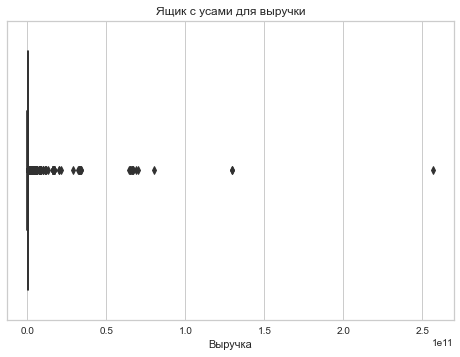

In [17]:
sns.boxplot(data['Выручка']).set(title='Ящик с усами для выручки');

Ящик с усами использует межквартильный размах. Тут также отсекаются выбросы через межквартильный размах

In [18]:
Q1 = np.percentile(data['Выручка'], 25)
Q3 = np.percentile(data['Выручка'], 75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR

data = data[(data['Выручка'] >= lower) & (data['Выручка'] <= upper)]


In [19]:
Q1, Q3, IQR

(6669000.0, 25000000.0, 18331000.0)

В качестве способов нормализации выбрана минимакс нормализация, которая лучше подошла для кластеризации, чем нормализация через Z статистику

Формула минимакс нормализации
$X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}}$
Где $X_{max}$ – максимальное значение в заданной выборке X, $X_{min}$ – минимальное, X- некоторый элемент выборки и $X_{norm}$ - новое значение элемента выборки X

In [20]:
scaler = MinMaxScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), columns= data.columns)
data

,Капитал,Чистая прибыль,Выручка
0,0.115875,0.562488,0.057448
1,0.115875,0.562438,0.090888
2,0.115873,0.562437,0.069335
3,0.115873,0.562436,0.081425
4,0.115875,0.562487,0.090688
...,...,...,...
41983,0.115878,0.562433,0.157105
41984,0.115969,0.562433,0.057408
41985,0.115908,0.562433,0.117226
41986,0.115903,0.562286,0.557707


Для определения количества кластеров был использован метод локтя. Суть метода заключается в минимизации суммы квадратов внутри кластерных расстояний (WCSS)

Определение количества кластеров методом локтя:


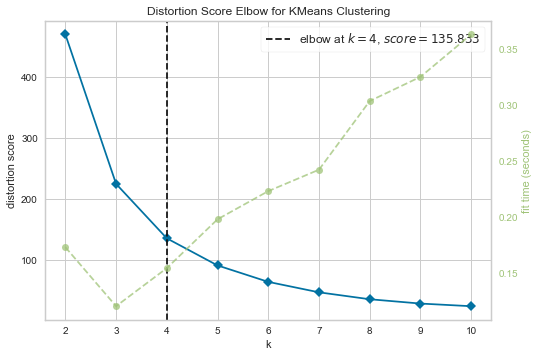

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
print('Определение количества кластеров методом локтя:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data)
Elbow_M.show()

Метод k - средних используется для задач кластеризации и заключается в минимизации среднеквадратичного отклонения точек кластеров – группы объектов от центров этих кластеров и выражается формулой:
    

$\sum_{i=1}^{k}\sum_{x\in S_i}\left(x-\mu_i\right)^2\rightarrow min $

Где k – число кластеров, $S_i$ – кластеры $i=1,\ 2,\ \ldots,\ k$ и $\mu_i $– центры масс векторов x кластеров $S_i$


In [22]:
kmeans = KMeans(n_clusters=4, random_state=0) 
yhat = kmeans.fit_predict(data)
data['Clusters'] = yhat

Исследование исследуемых признаков для заданных кластеров в пространстве

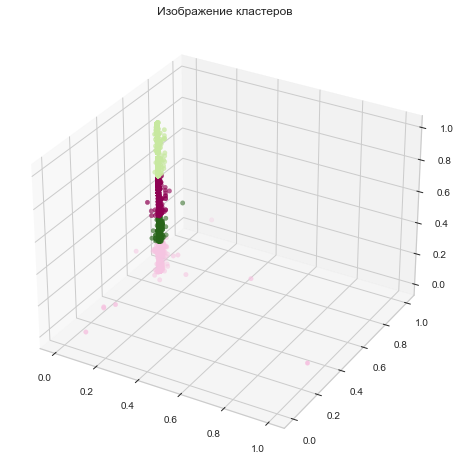

In [23]:
x = data["Капитал"]
y = data["Чистая прибыль"]
z = data["Выручка"]
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, c=data["Clusters"], marker='o', cmap="PiYG")
ax.set_title("Изображение кластеров")
plt.show()

Расчет количества кластеров. Кластеры не сбалансированы из-за экономических особенностей

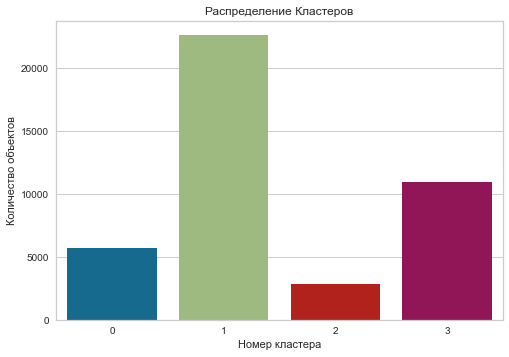

In [24]:
cnt = sns.countplot(x=data["Clusters"])
cnt.set_title("Распределение Кластеров")
plt.xlabel('Номер кластера')
plt.ylabel('Количество объектов')
plt.show()

Разметка кластеров в исходном датасете

In [25]:
df['Clusters'] = data['Clusters']
df[['Clusters','Капитал', "Выручка", "Чистая прибыль"]]

,Clusters,Капитал,Выручка,Чистая прибыль
0,1.0,20000000000,70000000000,4608000000
1,1.0,167000000000,80000000000,7472000000
2,1.0,6757000000,32000000000,5319000000
3,1.0,13000000000,29000000000,7901000000
4,1.0,49000000000,20000000000,188000000
...,...,...,...,...
50995,NaN,615200000,561300000,1825000
50996,NaN,65200000,144200000,189000
50997,NaN,198600000,479400000,427000
50998,NaN,247300000,462100000,2387000


Анализ полученных кластеров

In [26]:
a = df[df['Clusters']  == 0.0][['Дата регистрации', 'ОКВЭД (расшифровка)',
       'ОКФС (расшифровка)', 'ОКАТО (расшифровка)', "Капитал", 'Выручка', 'Чистая прибыль','rank', 'Наименование']]
a

,Дата регистрации,ОКВЭД (расшифровка),ОКФС (расшифровка),ОКАТО (расшифровка),Капитал,Выручка,Чистая прибыль,rank,Наименование
19,16 августа 1994 года,"Торговля оптовая твердым, жидким и газообразны...",Публичные акционерные общества,Тарко-Сале,15000000000,8047000000,6404000000,19,"ПАО ""НОВАТЭК"""
32,8 ноября 2000 года,Деятельность по управлению холдинг-компаниями,Непубличные акционерные общества,Крылатское,4225000000,1214000000,1103000000,32,"АО ""ХК ""МЕТАЛЛОИНВЕСТ"""
43,18 марта 2002 года,Производство сортового горячекатаного проката ...,Непубличные акционерные общества,Заводский,532000000,3653000000,428000000,43,"АО ""ЕВРАЗ ЗСМК"""
49,9 сентября 2002 года,Деятельность в области связи на базе проводных...,Публичные акционерные общества,Центральный,2784000000,3506000000,176000000,49,"ПАО ""РОСТЕЛЕКОМ"""
53,30 июня 1999 года,Добыча природного газа и газового конденсата,Общества с ограниченной ответственностью,Новый Уренгой,377000000,3826000000,38000000,53,"ООО ""ГАЗПРОМ ДОБЫЧА ЯМБУРГ"""
...,...,...,...,...,...,...,...,...,...
41971,18 октября 2018 года,"Торговля оптовая твердым, жидким и газообразны...",Общества с ограниченной ответственностью,Выхино-Жулебино,194000,12000000,119000,41971,"ООО ""РЕЙФОРЛИМИТЕД"""
41981,30 августа 2013 года,"Производство прочих химических продуктов, не в...",Общества с ограниченной ответственностью,Асбест,3047000,6535000,495000,41981,"ООО ""ПК ""СТИЛОБИТ"""
41982,24 декабря 2003 года,Обработка металлов и нанесение покрытий на мет...,Общества с ограниченной ответственностью,Пролетарский,287000,3901000,69000,41982,"ООО ""НОВАР"""
41986,28 июня 2017 года,"Торговля оптовая автомобильными деталями, узла...",Общества с ограниченной ответственностью,Кострома,3049000,17000000,2869000,41986,"ООО ""ПРОФЕССИОНАЛ ГЛОБАЛ"""


In [27]:
a.describe()


,Капитал,Выручка,Чистая прибыль,rank
count,5.449000e+03,5.449000e+03,5.449000e+03,5676.000000
mean,1.939568e+08,2.431298e+08,3.088842e+06,8463.399577
std,5.252147e+09,1.772301e+09,5.318637e+08,6417.298709
min,-2.426000e+09,0.000000e+00,-3.380000e+10,19.000000
25%,1.519000e+06,2.200000e+07,1.280000e+05,4614.500000
50%,6.361000e+06,4.200000e+07,1.072000e+06,6939.000000
75%,2.000000e+07,7.000000e+07,4.400000e+06,10197.000000
max,2.739000e+11,6.860000e+10,8.200000e+09,41987.000000


In [28]:
b = df[df['Clusters']  == 1.0][['Дата регистрации', 'ОКВЭД (расшифровка)',
       'ОКФС (расшифровка)', 'ОКАТО (расшифровка)', "Капитал", 'Выручка', 'Чистая прибыль','rank', 'Наименование']]
b

,Дата регистрации,ОКВЭД (расшифровка),ОКФС (расшифровка),ОКАТО (расшифровка),Капитал,Выручка,Чистая прибыль,rank,Наименование
0,7 декабря 1995 года,Добыча нефти,Публичные акционерные общества,Якиманка,20000000000,70000000000,4608000000,0,"ПАО ""НК ""РОСНЕФТЬ"""
1,25 февраля 1993 года,"Торговля оптовая твердым, жидким и газообразны...",Публичные акционерные общества,Черемушки,167000000000,80000000000,7472000000,1,"ПАО ""ГАЗПРОМ"""
2,6 октября 1995 года,"Торговля оптовая твердым, жидким и газообразны...",Публичные акционерные общества,Адмиралтейский,6757000000,32000000000,5319000000,2,"ПАО ""ГАЗПРОМ НЕФТЬ"""
3,22 апреля 1993 года,"Работы геолого-разведочные, геофизические и ге...",Публичные акционерные общества,Красносельский,13000000000,29000000000,7901000000,3,"ПАО ""ЛУКОЙЛ"""
4,23 сентября 2003 года,Деятельность железнодорожного транспорта: груз...,Публичные акционерные общества,Басманный,49000000000,20000000000,188000000,4,"ОАО ""РЖД"""
...,...,...,...,...,...,...,...,...,...
41977,14 ноября 2006 года,Деятельность в области архитектуры,Непубличные акционерные общества,Хорошево-Мневники,1754000,3309000,341000,41977,"АО ""АТЕК"""
41978,30 мая 2002 года,Производство лекарственных препаратов,Общества с ограниченной ответственностью,Хорошевский,22000000,1024000,-1808000,41978,"ООО ""НИАРМЕДИК ПЛЮС"""
41983,1 марта 2016 года,Перевозка грузов специализированными автотранс...,Общества с ограниченной ответственностью,Нижневартовск,123000,6380000,84000,41983,"ООО ""РА ЛИДЕР"""
41984,30 ноября 2015 года,"Торговля оптовая компьютерами, периферийными у...",Общества с ограниченной ответственностью,Таганрог,551000,8858000,821000,41984,"ООО ""НТКОМ"""


In [29]:
b.describe()

,Капитал,Выручка,Чистая прибыль,rank
count,2.165100e+04,2.165100e+04,2.165100e+04,22596.000000
mean,1.067021e+08,7.133985e+07,1.909170e+07,28311.297840
std,2.657319e+09,2.029643e+09,1.863829e+09,9539.519586
min,-3.380000e+10,-3.167000e+06,-4.100000e+09,0.000000
25%,5.430000e+05,6.697000e+06,3.600000e+04,22544.750000
50%,2.349000e+06,9.472000e+06,2.590000e+05,29733.500000
75%,1.300000e+07,1.400000e+07,9.875000e+05,35979.250000
max,2.719000e+11,2.569000e+11,2.729000e+11,41985.000000


In [30]:
c = df[df['Clusters']  == 2.0][['Дата регистрации', 'ОКВЭД (расшифровка)',
       'ОКФС (расшифровка)', 'ОКАТО (расшифровка)', "Капитал", 'Выручка', 'Чистая прибыль','rank', 'Наименование']]
c

,Дата регистрации,ОКВЭД (расшифровка),ОКФС (расшифровка),ОКАТО (расшифровка),Капитал,Выручка,Чистая прибыль,rank,Наименование
18,8 июля 2005 года,Производство нефтепродуктов,Публичные акционерные общества,Тобольск,8694000000,7312000000,2435000000,18,"ПАО ""СИБУР ХОЛДИНГ"""
28,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,28,"ООО ""ГЛОБУС"""
33,5 мая 2005 года,Торговля розничная аудио- и видеотехникой в сп...,Общества с ограниченной ответственностью,Басманный,156000000,4020000000,-72000000,33,"ООО ""МВМ"""
35,25 декабря 2003 года,Добыча нефти,Общества с ограниченной ответственностью,Ленинский,2393000000,5012000000,557000000,35,"ООО ""ЛУКОЙЛ-ПЕРМЬ"""
39,29 декабря 2011 года,"Торговля оптовая компьютерами, периферийными у...",Общества с ограниченной ответственностью,Арбат,43000000,854000000,-65000000,39,"ООО ""ЭППЛ РУС"""
...,...,...,...,...,...,...,...,...,...
41513,3 сентября 2015 года,Торговля оптовая металлами в первичных формах,Общества с ограниченной ответственностью,Приокский,1261000,5155000,246000,41513,"ООО МК ""ФЕРРО"""
41964,28 января 2014 года,"Добыча прочих полезных ископаемых, не включенн...",Общества с ограниченной ответственностью,Известковый,11000000,9025000,75000,41964,"ООО ""КБР"""
41969,13 октября 1999 года,"Производство прочих изделий из пластмасс, не в...",Общества с ограниченной ответственностью,Боровичи,1274000,6566000,198000,41969,"ООО ""ВИЛИНА"""
41973,11 февраля 2021 года,Торговля оптовая отходами и ломом,Общества с ограниченной ответственностью,Ленинский,32000,5624000,790,41973,"ООО ""КРАСМЕТ"""


In [31]:
c.describe()

,Капитал,Выручка,Чистая прибыль,rank
count,2.713000e+03,2.713000e+03,2.713000e+03,2809.000000
mean,3.261714e+08,5.574624e+08,3.949437e+07,3770.355643
std,4.177173e+09,4.469890e+09,5.164283e+08,5014.145701
min,-1.531000e+09,0.000000e+00,-4.100000e+09,18.000000
25%,3.648000e+06,5.700000e+07,2.890000e+05,1346.000000
50%,2.000000e+07,1.190000e+08,3.169000e+06,2404.000000
75%,6.800000e+07,2.330000e+08,1.300000e+07,4046.000000
max,1.372000e+11,1.292000e+11,1.690000e+10,41979.000000


In [32]:
d = df[df['Clusters']  == 3.0][['Дата регистрации', 'ОКВЭД (расшифровка)',
       'ОКФС (расшифровка)', 'ОКАТО (расшифровка)', "Капитал", 'Выручка', 'Чистая прибыль','rank', 'Наименование']]
d

,Дата регистрации,ОКВЭД (расшифровка),ОКФС (расшифровка),ОКАТО (расшифровка),Капитал,Выручка,Чистая прибыль,rank,Наименование
38,9 февраля 1999 года,Торговля оптовая табачными изделиями,Общества с ограниченной ответственностью,Мещанский,78000000,3999000000,49000000,38,"ООО ""ФМСМ"""
62,17 июня 1993 года,Деятельность в области связи на базе проводных...,Публичные акционерные общества,Тверской,1691000000,3132000000,860000000,62,"ПАО ""МЕГАФОН"""
89,27 июля 2021 года,Торговля розничная легковыми автомобилями и ле...,Непубличные акционерные общества,Химки,201000000,1607000000,96000000,89,"АО ""РОЛЬФ"""
131,26 декабря 2004 года,Производство электроэнергии гидроэлектростанци...,Публичные акционерные общества,Тверской,7542000000,1996000000,260000000,131,"ПАО ""РУСГИДРО"""
135,6 ноября 1992 года,"Производство стальных труб, полых профилей и ф...",Непубличные акционерные общества,Выкса,1365000000,1882000000,440000000,135,"АО ""ВМЗ"""
...,...,...,...,...,...,...,...,...,...
41917,20 августа 2004 года,Строительство жилых и нежилых зданий,Общества с ограниченной ответственностью,Центральный,-268000,1535000,-102000,41917,"ООО СК ""ГЕОСТРОЙ"""
41931,24 марта 1999 года,Производство кузовов для автотранспортных сред...,Непубличные акционерные общества,Курган,1346000,5070000,51000,41931,"АО ""КУРГАНСКИЕ ПРИЦЕПЫ"""
41957,11 октября 2012 года,Работы строительные отделочные,Общества с ограниченной ответственностью,Люберцы,4340,6037000,1570,41957,"ООО ""АРКТУРИАН"""
41967,14 мая 2001 года,Торговля оптовая черными металлами в первичных...,Общества с ограниченной ответственностью,Промышленный,768000,5066000,107000,41967,"ООО ""ТОРГОВЫЙ ДОМ""ЛИКОССТАЛЬПРОМ"""


In [33]:
d.describe()

,Капитал,Выручка,Чистая прибыль,rank
count,1.047300e+04,1.047300e+04,1.047300e+04,10907.000000
mean,2.839591e+07,7.341442e+07,4.590477e+06,16789.566975
std,4.294649e+08,1.192571e+09,7.674344e+07,7902.196810
min,-8.200000e+09,0.000000e+00,-7.440000e+08,38.000000
25%,7.200000e+05,1.100000e+07,6.800000e+04,11407.500000
50%,2.778000e+06,1.800000e+07,4.750000e+05,15779.000000
75%,8.344000e+06,2.700000e+07,1.755000e+06,20996.000000
max,3.230000e+10,6.660000e+10,4.100000e+09,41980.000000
